# State Space Models

State space modeling provides a unified methodology for treating a wide range
of problems in time series analysis. In this approach it is assumed that the
development over time of the system under study is determined by an (usually) unobserved
series of vectors $x_1,\dots,x_T$, with which are associated a series of observations (might contain missing values)
$y_1,...,y_T$; the relation between the $x_t’s$ and the $y_t’s$ is specified by its joint distribution

$$f(y_1,\dots,y_T,x_1,\dots,x_T)$$

A **State Space Models** in its most general form is probabilist model that satisfies

\begin{align*}
f(y_t|y_1,\dots,y_{t-1},x_1,\dots,x_t) &= f(y_t|x_t)\\
f(x_{t+1}|y_1,\dots,y_{t},x_1,\dots,x_t) &= f(x_{t+1}|x_t)\\
\end{align*}

It is also known as a latent Markov Model since the process $\{(y_t,x_t),t\geq 1\}$ is Markovian (not necessarily homogeneous):

$$f(y_{t+1},x_{t+1}|y_1,\dots,y_t,x_1,\dots x_t) = f(y_{t+1},x_{t+1}|y_t,x_t) $$

Hence we have a complete time-series model given by 3 densities

1. Observation Model: $Y_t|X_t=x_t\sim f(y_t|x_t)$
2. Transition Model: $X_{t+1}|X_t=x_t\sim f(x_{t+1}|x_t)$
3. Initial Condition $X_1\sim f(x_1)$


## Linear Gaussian State Space Models

The general linear Gaussian State Space model can be written in a variety of ways, we shall use the form:

\begin{align*}
y_t &= H_t x_t+\eta_t,\quad\eta_t\sim N(0,R_t)\\
x_{t+1} &= F_t x_t +\epsilon_t,\quad\epsilon_t\sim N(0,Q_t), \\
\end{align*}

where $y_t(p\times 1)$ is the vector of observations and $x_t(m\times 1)$ the state vector. The matrices $H_t(p\times m)$, $F_t(m\times m)$, $R_t(p\times p)$ are $Q_t(m\times m)$ initially assumed to be known and the error terms $\eta_t$ and $\epsilon_t$ are assumed to be serially independent and independent of each other for all $t$. The covariance matrices $R_t$ and $R_t$ might be positive semidefinite.


In [1]:
# SS Data Generation Function

SS = function(Model,T) {
  
  # Number of Observation T
  # Model with 4 matrices H(pxm), F(mxm), R(pxp) and Q(mxm)
  
  # Creating the Output Vectors and Matrices
  p = dim(Model$H)[1]
  m = dim(Model$F)[1]
  y = matrix(0,p,T)
  x = matrix(0,m,T+1)
  
  sqrtR = Model$R^0.5
  sqrtQ = Model$Q^0.5  
  
  for (t in 1:T) {
    y[,t] = Model$H %*% x[,t] + sqrtR %*% rnorm(p)
    x[,t+1] = Model$F %*% x[,t] + sqrtQ %*% rnorm(m)
  } 
  return(y)
}


---
**Example** Local Level Model is probably the simplest non-trivial example of a linear Gaussian state space model, if we include a slope term $\delta_t$ we  have the local linear trend model which is given by

\begin{align*}
y_t &= \mu_t+\eta_t,\quad\eta_t\sim N(0,\sigma^2_\eta)\\
\mu_{t+1} &= \mu_t +\delta_t +\omega_t,\quad\omega_t\sim N(0,\sigma^2_\omega) \\
\delta_{t+1} &= \delta_t +\xi_t,\quad\xi_t\sim N(0,\sigma^2_\xi)
\end{align*}

If we set $\omega_t=\xi_t=0$, then $\delta_{t+1}=\delta_t=\delta$ say, and the trend becomes exactly linear and the model reduces to the deterministic linear trend plus noise. Note that $\sigma^2_\omega>0$ and $\sigma^2_\xi>0$ allows for the level and slope to vary over time respectively.

We can put the local linear trend model in the SS representation as

$$x_t =\begin{pmatrix}\mu_t \\
\delta_t
\end{pmatrix};\quad H=(1\; 0);\quad R=\sigma^2_\eta;\quad F =\begin{pmatrix}1 & 1 \\
0 & 1
\end{pmatrix};\quad \epsilon_t =\begin{pmatrix}\omega_t \\
\xi_t
\end{pmatrix};\quad Q=\begin{pmatrix}\sigma^2_\omega & 0 \\
0 & \sigma^2_\xi
\end{pmatrix}$$


**Example** ARMA(p,q) model in a state space representation. Let $m=\max(p,q+1)$, set $R_t=0$ and $Q_t=\sigma^2$ and define the companion matrix

$$F=\begin{pmatrix}\psi_1 & \psi_2 &\dots &\psi_{m-1} &\psi_m\\
1 & 0 &\dots & 0 & 0\\
0 & 1 &\dots & 0 & 0\\
\vdots & \vdots &\ddots & \vdots & \vdots\\
0 & 0 &\dots & 1 & 0\\
\end{pmatrix},\qquad H= \begin{pmatrix} 1 &\phi_1 & \dots &\phi_{m-1} \end{pmatrix}, $$

where we set $\psi_j=0$ for $j>p$ and $\phi_j=0$ for $j>q$.
Then the ARMA(p,q) can be written in state space from as 

\begin{align*}
y_t &= H x_t\\
x_{t+1} &= F x_t +\epsilon \\
\end{align*}



---



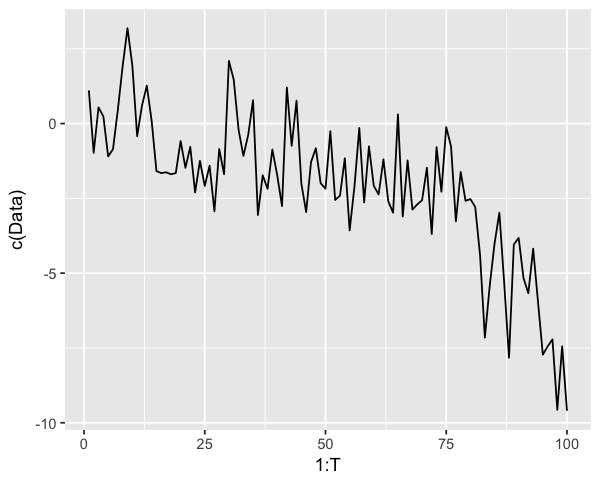

In [11]:
# Local Linear Trend Model

    LLTM = list(H = matrix(c(1,0),1,2),
                R = matrix(1),
                F = matrix(c(1,0,1,1),2,2),
                Q = diag(c(0.5,0.001))
                )

    T = 100
    Data = SS(LLTM,T)

# Plotting
library(ggplot2)
library(repr)
options(repr.plot.width=5, repr.plot.height=4)

qplot(1:T,c(Data),geom = "line")

## Kalman Filter

The great advantage of the Linear Gaussian model is that all the distributions are Gaussian so that all the conditionals will be Gaussian hence we need only to specify mean and variance for each of them. For instance we know that the filtered distribution $f(x_t|y_{1:t})$ will be Gaussian and we need to find $a_{t|t}\equiv\mathbb{E}(x_t|y_{1:t})$ and $V_{t|t}\equiv\mathbb{V}(x_t|y_{1:t})$. From the transition equation:

\begin{align*}
a_{t+1|t}&\equiv\mathbb{E}(x_{t+1}|y_{1:t}) =\mathbb{E}(F_tx_t+\epsilon_t|y_{1:t})= F_t a_{t|t}\\
V_{t+1|t} &\equiv\mathbb{V}(x_{t+1}|y_{1:t})=\mathbb{V}(F_tx_t+\epsilon_t|y_{1:t})=F_tV_{t|t}F'_t + Q_t
\end{align*}

Now we need an expression for $a_{t|t}$ and $V_{t|t}$. First, define the one step ahead prediction error using the observation equation

$$\nu_t\equiv y_t-\mathbb{E}(y_t|y_{1:t-1}) = y_t - \mathbb{E}(H_t x_t+\eta_t|y_{1:t-1})=y_t-H_t a_{t|t-1}$$

Now using the properties of the multivariate normal distribution we have

\begin{align*}
a_{t|t}&\equiv\mathbb{E}(x_{t}|y_{1:t}) =  \mathbb{E}(x_{t}|y_{1:t-1},\nu_t) = \mathbb{E}(x_{t}|y_{1:t-1}) + \mathbb{C}(x_t,\nu_t)\left[\mathbb{V}(\nu_t)\right]^{-1}\nu_t\\
V_{t|t} &\equiv\mathbb{V}(x_{t}|y_{1:t})=\mathbb{V}(x_{t}|y_{1:t-1},\nu_t)=\mathbb{V}(x_{t}|y_{1:t-1})-\mathbb{C}(x_t,\nu_t)\left[\mathbb{V}(\nu_t)\right]^{-1}\mathbb{C}(x_t,\nu_t)'
\end{align*}

We can derive an expression for both the variance and the covariance matrices since

\begin{align*}
\mathbb{C}(x_t,\nu_t)&=\mathbb{E}\left[\mathbb{E}(x_t(H_t x_t+\eta_t-H_t a_t)|y_{1:t-1})\right]=\mathbb{E}\left[\mathbb{E}(x_t(x_t- a_t)'H_t'|y_{1:t-1})\right]=V_{t|t-1}H_t'\\
\mathbb{V}(\nu_t) &= \mathbb{V}(H_t(x_t-a_t)+\eta_t) =\mathbb{E}\left[\mathbb{V}(H_t(x_t-a_t)+\eta_t|y_{1:t-1}\right] = H_t V_{t|t-1} H_t'+ R_t
\end{align*}

Hence, starting from a known $a_{1|0}$ and $V_{1|0}$ we can recursively $(t=1,\dots T)$ calculate the update equations of the the filter

\begin{align*}
\nu_t &= y_t-H_t a_{t|t-1}\\
S_t &= H_t V_{t|t-1} H_t'+ R_t\\
K_t &= V_{t|t-1}H_t'S_t^{-1}\\
a_{t|t}& = a_{t|t-1} + K_t\nu_t\\
V_{t|t} &=(I_m-K_t H_t)V_{t|t-1},
\end{align*}

where $K_t$ is known as the **kalman filter gain** and the prediction equations

\begin{align*}
a_{t+1|t}& = F_ta_{t|t}\\
V_{t+1|t} &=F_tV_{t|t}F'_t + Q_t
\end{align*}

Therefore the filtered density is given by

$$X_t|Y_{1:t}=y_{1:t}\sim N(a_{t|t},V_{t|t})$$


In [3]:
# Kalman Filter

KF = function(Data,Model) {
  
  # Data as matrix (pxT)
  # Model has 4 matrices H(pxm), F(mxm), R(pxp) and Q(mxm)
  
  # Creating the Output Vectors and Matrices
  p = dim(Data)[1]
  T = dim(Data)[2]
  m = dim(Model$F)[1]
  v = y_hat = matrix(0,p,T)
  a = matrix(0,m,T)
  a_minus = matrix(0,m,T+1)
  S = array(0,dim = c(p,p,T))
  V = array(0,dim = c(m,m,T))
  V_minus = array(0,dim = c(m,m,T+1))
  K = array(0,dim = c(m,p,T))  
  
  for (t in 1:T) {
    i=!is.na(Data[,t])  # Find the non-missing  
    y_hat[,t] = Model$H %*% a_minus[,t] # Filtered Values
    H = Model$H[i,,drop = FALSE]
    R = Model$R[i,i,drop=FALSE]  
      
    # Update Equations
    v[i,t] = Data[i,t] - H %*% a_minus[,t,drop = FALSE]
    S[i,i,t] = H %*% V_minus[,,t] %*% t(H) + R
    if (any(i)) K[,i,t] = V_minus[,,t] %*% t(H) %*% solve(S[i,i,t]) 
    a[,t] = a_minus[,t] + K[,i,t] %*% v[i,t,drop=FALSE]
    V[,,t] = (diag(m) - K[,i,t] %*% H) %*% V_minus[,,t]
    # Forecast Equations
    a_minus[,t+1] = Model$F %*% a[,t]
    V_minus[,,t+1] = Model$F %*% V[,,t] %*%  t(Model$F) + Model$Q
  }
  return(list(v=v,S=S,K=K,a=a,a_minus=a_minus[,-(T+1)],V=V,V_minus=V_minus[,,-(T+1)],y_hat=y_hat))  
}

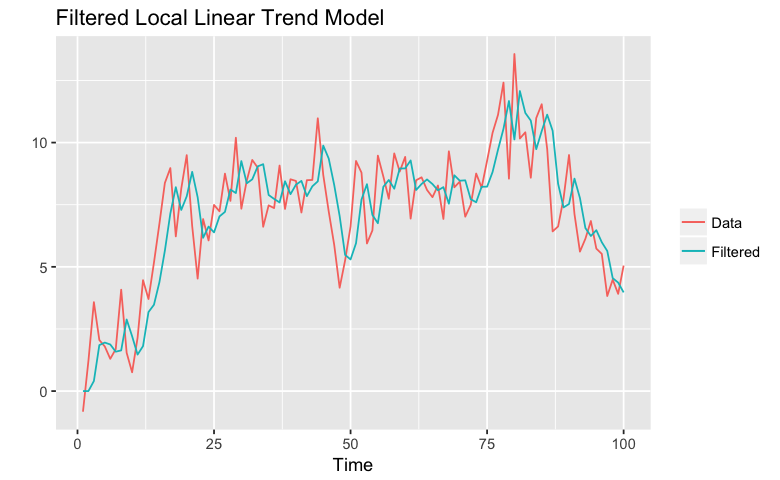

In [4]:
# Applying the KF in the LLTM

Out = KF(Data,LLTM)

options(repr.plot.width=6.5, repr.plot.height=4)

plot_data = data.frame(time = 1:T,
                       true = c(Data),
                       filtered = c(Out$y_hat),
                       sd = sqrt(c(Out$S))
                      )
nsd = 2
ggplot(plot_data, aes(x = time)) + 
  geom_line(aes(y = true, colour = "Data")) +
  geom_line(aes(y = filtered, colour = "Filtered")) +
 # geom_line(aes(y = filtered + nsd*sd, colour = "UB")) +
 # geom_line(aes(y = filtered - nsd*sd, colour = "LB")) +
 # theme(legend.position = c(0.8, 0.8)) +
  theme(legend.title=element_blank()) +
  ggtitle("Filtered Local Linear Trend Model") +
  xlab("Time") +
  ylab("")


## Likelihood

The data likelihood can be easily computed using the filtering process above since

$$f(y_{1:T})=\prod_{t=1}^T f(y_t|y_{1:t-1}),$$

where $f(y_1|y_{1:0})\equiv f(y_1)$.
We know that $f(y_t|y_{1:t-1})$ is gaussian and from the Kalman filter we have 

\begin{align*}
\mathbb{E}(y_t|y_{1:t-1}) &= \mathbb{E}(H_t x_t + \eta_t|y_{1:t-1})=  H_t a_{t|t-1}\\
\mathbb{V}(y_t|y_{1:t-1}) &= \mathbb{V}(\nu_t) =S_t. 
\end{align*}

Hence if we denote $\phi(x,\mu,\Sigma)$ the multivariate guassian density with mean $\mu$ and covariance $\Sigma$ we have

$$f(y_t|y_{1:t-1})=\phi(y_t;H_t a_{t|t-1},S_t)=\phi(\nu_t;0,S_t)$$


Taking the log we are left with the log-likelihood in what is called the **prediction error decomposition**

$$\log f(y_{1:T})=-\frac{Tp}{2}\log 2\pi-\frac{1}{2}\sum_{t=1}^T\left(\log|S_t|+\nu_t'S_t^{-1}\nu_t\right)$$



In [5]:
# Log-Likelihood for Gaussian Linear SS model

LLF = function(Data,Model) {
  
  # Data as matrix (pxT)
  # Model has 4 matrices H(pxm), F(mxm), R(pxp) and Q(mxm)

  # Call the Kalman Filter Function
  Filtered = KF(Data,Model)
  S = Filtered$S
  v = Filtered$v
  T = dim(Data)[2] 
  p = dim(Data)[1]  
  
  L = T*p*log(2*pi)/2
  for (t in 1:T) L = L + 0.5*(log(det(S[,,t]))+ t(v[,t])%*%solve(S[,,t])%*%v[,t])
  return(-L)
}

## Forecast

Suppose you have the observations $y_1,\dots, y_T$ from a gaussian state space linear model and you wish to forecast $y_{T+1},\dots,y_{T+h}$, i.e., up to $h$ steps ahead. Clearly the predictive density will be gaussian so we are left to specify its mean $\widehat{y}_{T+j}\equiv\mathbb{E}(y_{T+j}|y_{1:T})$ and variance $\widehat{V}_{T+j}\equiv\mathbb{V}(y_{T+j}|y_{1:T})$ for $j=1,\dots h$. From the observation equation we have

\begin{align*}
\widehat{y}_{T+j}&\equiv \mathbb{E}(y_{T+j}|y_{1:T}) = \mathbb{E}(H_{T+j} x_{T+j} + \eta_{T+j}|y_{1:T})=  H_{T+j} a_{T+j|T}\\
\widehat{V}_{T+j}&\equiv \mathbb{V}(y_{T+j}|y_{1:T}) = \mathbb{V}(\nu_{T+j}) =H_{T+j} V_{T+j|T} H_{T+j}' + R_{T+j}. 
\end{align*}

We now need a recursion for to calculate $a_{T+j|T}$ and $a_{T+j|T}$ which can be obtain directly from the transition equation since

\begin{align*}
a_{T+j|T}&\equiv\mathbb{E}(x_{T+j}|y_{1:T}) =\mathbb{E}(F_{T+j}x_{T+j-1}+\epsilon_{T+j}|y_{1:t})= F_{T+j} a_{T+j-1|T}\\
V_{T+j|T} &\equiv\mathbb{V}(x_{T+j}|y_{1:T})=\mathbb{V}(F_{T+j}x_{T+j-1}+\epsilon_{T+j}|y_{1:t})=F_{t+j}V_{T+j-1|T}F'_{t+j} + Q_{T+j}
\end{align*}

Starting from $j=1$ we can use the equations above to calculate $(a_{T+j|T},V_{T+j|T})_{j=1}^h$, which can the plugged in the former set of equations to obtain the mean and the variance of the forecast density

$$Y_{T+j}|Y_{1:T}=y_{1:T}\sim N(\widehat{y}_{T+j},\widehat{V}_{T+j})$$

Notice that the recursion to obtain $(a_{T+j|T},V_{T+j|T})_{j=1}^h$ t is equivalent to run the Kalman Filter out-of-sample with $K_t=0$ and $v_t=0$ for $t=T+1,\dots, h$. Thus, forecasting is a trivial exercise once the filter in implemented.




In [6]:
# Kalman Filter + Forecast

SSForecast = function(Data,Model,h) {
  
  # Data as matrix (pxT)
  # Model has 4 matrices H(pxm), F(mxm), R(pxp) and Q(mxm)
  # Number of steps ahead to be forecasted h>0 
  
  Expand.Data = cbind(Data,matrix(NA,p,h))
  # Call the Kalman Filter Function  
  Forecast = KF(Expand.Data,Model) 
  return(Forecast)  
}

Warning message:
“Removed 5 rows containing missing values (geom_path).”

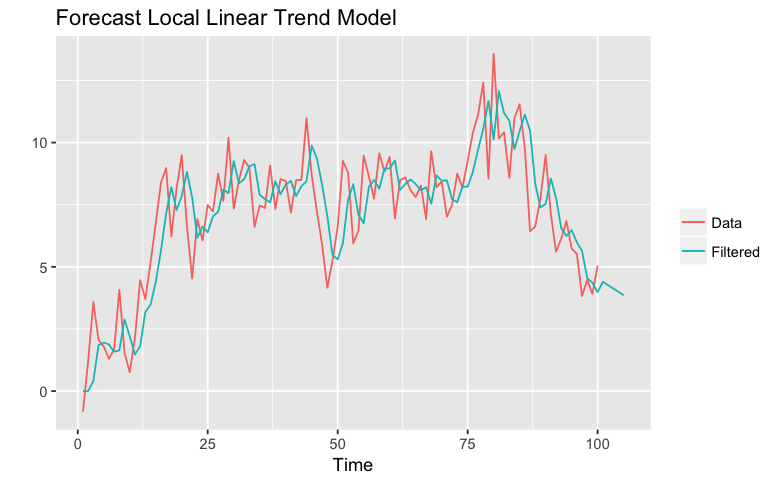

In [7]:
# Forecasting the LLTM 
p = 1
h = 5
Out = SSForecast(Data,LLTM,h)

options(repr.plot.width=6.5, repr.plot.height=4)

Expand.Data = cbind(Data,matrix(NA,p,h))

plot_data = data.frame(time = 1:(T+h),
                       true = c(Expand.Data),
                       filtered = c(Out$y_hat),
                       sd = sqrt(c(Out$S))
                      )
nsd = 2
ggplot(plot_data, aes(x = time)) + 
  geom_line(aes(x = time,y = true, colour = "Data")) +
  geom_line(aes(y = filtered, colour = "Filtered")) +
 # geom_line(aes(y = filtered + nsd*sd, colour = "UB")) +
 # geom_line(aes(y = filtered - nsd*sd, colour = "LB")) +
 # theme(legend.position = c(0.8, 0.8)) +
  theme(legend.title=element_blank()) +
  ggtitle("Forecast Local Linear Trend Model") +
  xlab("Time") +
  ylab("")


## Missing Values

Now Suppose that for some periods $t\in\mathcal{T}\subset \{1,\dots,T\}$ we have missing values for all or some of the $p$ variables of $y_t$. Let $y_t^*$ denote the values that are not missing in time $t$, constructed as $y_t^*\equiv C_t y_t$ where the matrix $C_t(r_t\times p)$ has some rows of $I_p$ for $r_t=0,1,\dots,p$.
If we premultiply the observation equation to $C_t$ we obtain

$$y_t^*=H_t^*x_t+\epsilon_t^*,\quad\epsilon^*_t\sim N(0,Q_t^*),$$

where $H_t^*\equiv C_t H_t$, $\epsilon_t^* = C_t\epsilon_t$ and $Q_t^*= C_t Q_t C_t'$.

Notice that this modification leaves the dynamics of $a_{t|t}$ and $V_{t|t}$ unchanged in he Kalman Filter.

\begin{align*}
\nu_t^* &= y_t^*-H_t^* a_{t|t-1}\\
S_t^* &= H_t^* V_{t|t-1} {H_t^*}'+ R_t^*\\
K_t^* &= V_{t|t-1}{H_t^*}'{S_t^*}^{-1}\\
a_{t|t}& = a_{t|t-1} + K_t^*\nu_t^*\\
V_{t|t} &=(I_m-K_t^* H_t^*)V_{t|t-1}\\
a_{t+1|t}& = F_ta_{t|t}\\
V_{t+1|t} &=F_tV_{t|t}F'_t + Q_t,
\end{align*}

where we set $v_t^*=0$ and $K_t^*=0$ if $r_t=0$ for $t=1,\dots,T$.

## Parameter Estimation and Inference via Bayesian Approach

Until now all the analysis were carried out as the matrices of the SS Model were known. In reality those matrices are function of structural parameters $\theta\in\mathbb{R}^k$. I.e., there known functional forms such that $H=H(\theta)$, $F=F(\theta)$, $R=R(\theta)$ and $Q=Q(\theta)$, so that the likelihood function can be expressed for fixed $\theta$ as

$$f(y|\theta)=\prod_{t=1}^T\phi(\nu_t;0,S_t)$$

, which can be easily evaluated with the aid of the Kalman Filter.

Now given a prior distribution for parameters $\pi(\theta)$ the posterior can be evaluated up to a proportionally constant as

$$p^*(\theta|y)=f(y_{1:T}|\theta)\pi(\theta)$$

Due to the arbitrary functional format of the matrices. You are most likely would not be able to draw from the posterior in other to obtain a histogram or any point estimators discussed previously. In general we need an MCMC procedure which will required a run of the Kalman filter at each step of the Markov Chain. A general procedure would be to use the Metropolis Hasting algorithm to draw fro the posterior given that you can evaluate the posterior as: 

---
** Gaussian Linear SS Estimation Procedure **

1. From a given $\theta$ Compute the matrices $H=H(\theta)$, $F=F(\theta)$, $R=R(\theta)$ and $Q=Q(\theta)$
2. Using the data run the Kalman Filter to obtain $\{\nu_t,S_t\}_{t=1}^T$
3. Calculate the likelihood $f(y|\theta)$
4. Combine the likelihood with the prior to compute the posterior $p^*(\theta|y)=f(y|\theta)\pi(\theta)$


### DSGE Estimation

Given a $m$-dimensional vector of (state) variables $x_t$, a vector of parameters $\theta\in\Theta\subseteq\mathbb{R}^k$ and a vector iid shocks $\epsilon_t\sim(0,I)$ , most of the DSGE in economics is an expression of the form

$$\mathbb{E}_t\left[M(w_{t-1},w_{t},w_{t+1},\epsilon_t,\theta)\right]=0$$

After proper log-linearization around a stead steady (if exists) we have

$$\Gamma_0(\theta) x_t =\Gamma_1(\theta)\mathbb{E}_t x_{t+1} + \Gamma_2(\theta) x_{t-1} +\Gamma_3(\theta)\epsilon_t $$

Assuming there is a unique stable solution to the rational expectation model given by

$$x_{t+1} = A(\theta)x_{t} + B(\theta)\epsilon_t$$ 

Finallly, if we including the observational equation $y_t = C x_t$ where $C$ is just the $(p\times m)$ matrix that picks the $p$ observables in $x_t$ we have the log-linearized DSGE in the linear SS format

\begin{align*}
y &= C x_t\\
x_{t+1} &= A(\theta) x_t + B(\theta)\epsilon_t
\end{align*}

Unfortunately, the map $\theta\mapsto (A(\theta), B(\theta))$ cannot be made explicit analitically since it relies on the  expectation model solution such as Blanchard & Khan, Sims or Klein. Therefore you have to solve the linear expectation model for each draw of $\theta$ in order to compute the likelihood (consequenly the posterior) for each step in the Metropolis Hasting.

Below it is outlined a SINGLE loop of a DSGE Baysian estimation:

1. Given $\theta$, draw from the proposal distribution $\theta'\sim q(\theta'|\theta)$
1. Solve the Linear Expectation Model to obtain $\theta'\mapsto (A(\theta'), B(\theta'))$
2. Run the Kalman filter to compute the likelihood $(y, A(\theta'),B(\theta'))\mapsto f(y|\theta')$
3. Given the prior $\pi(\theta')$, calculate the unnormalized posterior as $p(\theta'|y)\propto f(y|\theta')\pi(\theta')$
4. Accept $\theta'$ with probability $\min\left(1,\frac{p(\theta'|y)}{p(\theta|y)}\right)$



## Non-Linear non-Gaussian SS Models

Recall that a Generic (non-linear and/or non-Guassian) SS model is described by 3 componentes

1. Observation Model: $Y_t|X_t=x_t\sim f(y_t|x_t)$
2. Transition Model: $X_{t+1}|X_t=x_t\sim f(x_{t+1}|x_t)$
3. Initial Condition $X_1\sim f(x_1)$



---
** Example: **

The stochastic volatility (SV) mode became a understand way to model the empirical fact known as *volatility cluster*. An alternative to model volatility cluster is to use an autoregressive conditional heteroscedasticity (ARCH) model. 

Consider first that the prices are log-normally distributed hence the return (log-return) $y_t$ are normally distributed as the the Black-Scholes formulation 

$$y_t = \mu + \eta_t,\quad\eta_t\sim N(0,\sigma^2)$$

where $\mu$ is the average return and $\sigma$ the constant volality of the asset. The first extension would be to consider a stochastic version of the volatility. Hence $\sigma_t$ is an unobservable state in our model. For convenience it is easier to set $\sigma_t = \sigma \exp(x_t)$ and model $x_t$ as an zero-mean AR(1) for instance

$$x_{t+1} = \rho x_{t}+\epsilon_t,\quad\epsilon_t\sim N(0,\omega^2)$$

Another extension would be to model the average return $\mu$ also as an stochastic component as in the local level model such that $\mu_t=\mu\exp(z_t)$ and 

$$z_{t+1} = z_{t+1} + \zeta_t, \quad \zeta\sim(0,\lambda^2) $$

A somewhat less artificial modeling for $\mu_t$ is to consider the *risk premium* rational where traders require a higher premium in volality markets which translate into model the oscillation in the both $\mu_t$ and $\sigma_t$ with respect to the same state as the model becomes:

\begin{align*}
y_t &= \mu\exp(x_t) + \sigma \exp(x_t)\eta_t\\
x_{t+1} &= \rho x_{t}+\epsilon_t
\end{align*}

Finally both $\eta_t$ and $\epsilon_t$ may not necessaily be Gaussian. In fact, the empirical evidence is of excess kurtosis on financial returns so heavy tailed distribution like t-Student of Generalized Gaussian must be considered instead

---

### Posterior Density

For notational convenience let $y = (y_1,\dots, y_T)$ and $x = (x_1,\dots, x_T)$. Hence for a general SS model with a vector of (random) parameters $\Theta$, we can describe the joint distribution of $(Y_1,\dots, Y_T, X_1,\dots,X_T)$ conditional on $\Theta=\theta$ as:

$$f(y,x|\theta)=f(x_1|\theta)\prod_{t=2}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta)$$

Also we can write the posterior of the unobservable $(\Theta,X)$ conditional on the data $Y=y$ as

\begin{align*}
p(\theta,x|y) &= \frac{f(y|\theta,x) f(\theta, x)}{f(y)}\\
&= \frac{f(y,x|\theta) f(\theta, x)}{f(x|\theta)f(y)}\\
&= \frac{f(y,x|\theta) f(x|\theta)\pi(\theta)}{f(x|\theta)f(y)}\\
&= \frac{f(x_1|\theta)}{f(y)}\pi(\theta)\prod_{t=2}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta) \\
\end{align*}

Therefore the posterior can be recovered by marginalization with respect to $X$:

$$p(\theta|y)=\int p(\theta,x|y)\mathrm{d} x = \frac{\pi(\theta)}{f(y)}\int f(x_0|\theta)\prod_{t=1}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta)\mathrm{d} x $$

Unfortunately the integral above cannot be evaluated analitically thus we do not have a simple way to evaluate the posterior at a given $\theta$ to build a MCMC or importance sampling algorithm. So the idea is to work with $p(\theta,x|y)$

### Point Estimators

Here we consider estimands that are a functional of the state vectors and/or the parameter vectors in the form of

$$\bar{g} \equiv \mathbb{E}[g(X, \Theta)|y]$$

these includes among others

* The posterior mean when $g(X,\Theta)=\Theta$ or its variance when $g(X,\Theta)=\Theta\Theta'$
* The mean of the smoothed state  $g(X)=X$ or its variance $g(X,\Theta)=XX'$

\begin{align*}
\mathbb{E}[g(X,\Theta)|y]& = \int\int g(x,\theta)p(x,\theta|y)\mathrm{d}x\mathrm{d}\theta\\
& = \frac{1}{m(y)}\int\int g(x,\theta)\pi(\theta) f(x_1|\theta)\prod_{t=2}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta)\mathrm{d}x\mathrm{d}\theta\\
& \equiv \frac{1}{m(y)}\mathbb{E}_q \left[g(X,\Theta)w(X,\Theta,y)\right]\\
\end{align*}

where 
\begin{align*}
q(x,\theta) &\equiv f(x_1|\theta)\prod_{t=2}^Tf(x_t|x_{t-1},\theta) \pi(\theta)\\
w(X,\Theta,y) &\equiv \prod_{t=2}^Tf(y_t|X_t,\Theta)
\end{align*}

Notice that if we take $g(x,\theta)=1$ we have that the marginal of the data is given by

$$m(y)=\mathbb{E}_q\left[w(X,\Theta,y)\right] $$

Therefore:

$$\mathbb{E}[g(X,\Theta)|y] = \frac{\mathbb{E}_q \left[g(X,\Theta)w(X,\Theta,y)\right]}{\mathbb{E}_q\left[w(X, \Theta ,y)\right]}$$

Let $\{\theta^{(i)}, x^{(i)}\}_{i=1}^n$ be iid draws from $q(x,\theta)$ hence we can estimate the above quantity by

$$\widehat{g} \equiv \frac{\sum_{i=1}^n g(\theta_i,x_i)w(\theta^{(i)},x^{(i)},y)}{\sum_{i=1}^n w(\theta^{(i)},x^{(i)},y)}$$

Given the 3 densities of the SS Model (observational, transitional and intial) and a prior is not difficult to sample from $q$ by repeating the following step $n$ times

0. Draw $\theta^{(i)}\sim\pi(\theta)$
1. Draw $x_1^{(i)}\sim f(x_1|\theta^{(i)})$
2. Draw $x_2^{(i)}\sim f(x_2|x_1^{(i)},\theta^{(i)})$
3. Draw $x_3^{(i)}\sim f(x_3|x_2^{(i)},\theta^{(i)})$

$\qquad\vdots$

5. Draw $x_T^{(i)}\sim f(x_T|x_{T-1}^{(i)},\theta^{(i)})$


#### Importance Sampling

If for some reason a sampler from $f(y_t|x_t,\theta)$ and or $f(x_t|x_{t-1},\theta)$ is not available we can still apply the method using a important sampler $q^*(x,\theta|y)$ that is easier to sample from

\begin{align*}
\mathbb{E}[g(X,\Theta)|y]& = \int\int g(x,\theta)p(x,\theta|y)\mathrm{d}x\mathrm{d}\theta\\
& = \frac{1}{m(y)}\int\int g(x,\theta)\pi(\theta) f(x_1|\theta)\prod_{t=2}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta)\mathrm{d}x\mathrm{d}\theta\\
& = \frac{1}{m(y)}\int\int g(x,\theta)\frac{\pi(\theta) f(x_1|\theta)\prod_{t=1}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta)}{q^*(\theta,x|y)}q^*(\theta,x|y)\mathrm{d}x\mathrm{d}\theta\\
& \equiv \frac{1}{m(y)}\int\int g(\theta)z(\theta,x,y)q^*(\theta,x|y)\mathrm{d}x\mathrm{d}\theta\\
& \equiv \frac{1}{m(y)}\mathbb{E}_{q^*} \left[g(\theta)w^*(\theta,x,y)\right]\\
\end{align*}

where

$$w^*(\theta,x,y) \equiv \frac{\pi(\theta) f(x_1|\theta)\prod_{t=1}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta)}{q^*(\theta,x|y)}$$

Notice that if we take $g(\theta)=1$ we have that $m(y)=\mathbb{E}_{q^*}\left[w^*(\theta,x,y)\right] $ hence

$$\mathbb{E}[g(X,\Theta)|y] = \frac{\mathbb{E}_{q^*} \left[g(X,\Theta)w(X,\Theta,y)\right]}{\mathbb{E}_{q^*}\left[w^*(X, \Theta ,y)\right]}$$

Let $\{\theta^{(i)}, x^{(i)}\}_{i=1}^n$ be iid draws from $q^*(\theta,x|y)$ hence we can estimate $\mathbb{E}[h(\theta)|y]$ by:

$$\bar{g} = \frac{\sum_{i=1}^n g(\theta_i)w^*(\theta^{(i)},x^{(i)},y)}{\sum_{i=1}^n w^*(\theta^{(i)},x^{(i)},y)}$$

How can we choose $q^*$? Well we can mimic the original SS model as 

$$q^*(\theta, x|y) = q^*(\theta|y) q^*(x|\theta, y) =  q^*(\theta|y) q^*(x_1|\theta, y)\prod_{t=2}^T q^*(x_t|x_{t-1},\theta,y )$$

we can take $q^*(\theta|y)=\pi(\theta)$ is the support of the prior is not constrained and $q^*(x_1|\theta, y)\sim N(,)$ and $q^*(x_t|x_{t-1}\theta, y)\sim N(,)$   

#### Forecast

If the interest is in a point estimator of future values of both the observable and/or the state

$$\bar{h} \equiv \mathbb{E}[h(X_{T+j}, Y_{T+j})|y],\quad j\geq 1$$

these includes among others

* The mean observable forecast when $h(X_{T+j},Y_{t+j})=Y_{t+j}$ and its variance $h(X_{T+j},Y_{t+j})=Y_{t+j}Y_{t+j}'$
* The mean state forecast when $h(X_{T+j},Y_{t+j})=X$ and its variance $h(X_{T+j},Y_{t+j})=Y_{t+j}Y_{t+j}'$

Recall that 

$$ \mathbb{E}[h(X_{T+j}, Y_{T+j})|y] = \mathbb{E}\left[\mathbb{E}(h(X_{t+j}, Y_{T+j}|x_{T+j})|y\right] \equiv  \mathbb{E}\left[g^*(X_{T+j})|y\right]$$

Hence we have the same format was the one discussed in the previus section expect that know we have state up to time $T+j$. However,  we can always advance the simulation of the smoother to include $t=T+1,\dots, T+j$. For the case of a simple mean forecast with a model given by additive zero mean error term in the form $Y_t = H(X_t,\Theta)+\eta_t$, then for the mean and variance respectively we have

\begin{align*}
g^*(X_{T+j}) &= \mathbb{E}(Y_{T+j}|x_{T+j}) = \mathbb{E}( H(X_{T+j},\Theta)+\eta_{T+j}|x_{T+j})= H(X_{T+j},\Theta)\\
g^*(X_{T+j}) &= \mathbb{E}(Y_{T+j}Y_{T+j}'|x_{T+j}) = \mathbb{E}\left[ (H(X_{T+j},\Theta)+\eta_{T+j})(H(X_{T+j},\Theta)+\eta_{T+j})'|x_{T+j}\right]= H(X_{T+j},\Theta) H(X_{T+j},\Theta)' + R(\theta)
\end{align*}

### MCMC

If we are interested in more complex (infinite dimensional) estimands such as the posterior density, predictive density or the state density you need some sort of MCMC procedure. However, as mentioned previously we do not, in general, possess a way to evaluate the posterior for a given $\theta$ 

Thus we will need to build a MCMC procedure taking both the parameters and the states together, i. e., we will draw from the joint posterior density $p(x,\theta|y)$.However, the dimension can become quite big since for $k$ parameters and $m$ state variables for $T$ periods each draw of the MCMC will be a vector of $k+ mT$. 

For instance, in a symmetric  random walk Metropolis-Hastings procedure starting from $(\theta, x)$ we draw $(\theta', x')$ from the proposed random walk and accept it by probability given by

$$\min\left(1,\frac{\pi(\theta')f(x_1|\theta')\prod_{t=2}^Tf(y_t|x_t',\theta)f(x_t'|x_{t-1}',\theta)}{\pi(\theta)f(x_1|\theta)\prod_{t=2}^Tf(y_t|x_t,\theta)f(x_t|x_{t-1},\theta)}\right)$$

After repeating it $n$ times (for large n) we expect to have a sample drawn from $p(x,\theta|y)$, then we can conduct a Monte Carlos integral for point estimators
